In [120]:
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container {width: 100% !important; }</style>"))
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 22, 7

In [121]:
import numpy as np 
import pandas as pd 
import pandas_datareader as data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from keras.layers import Dense, Dropout, LSTM 
from keras.models import Sequential
from tensorflow.keras.models import load_model

In [122]:
df = data.DataReader('AMZN', 'yahoo', '1997-05-15', '2021-07-01')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
1997-05-15,2.500000,1.927083,2.437500,1.958333,72156000.0,1.958333
1997-05-16,1.979167,1.708333,1.968750,1.729167,14700000.0,1.729167
1997-05-19,1.770833,1.625000,1.760417,1.708333,6106800.0,1.708333
1997-05-20,1.750000,1.635417,1.729167,1.635417,5467200.0,1.635417
1997-05-21,1.645833,1.375000,1.635417,1.427083,18853200.0,1.427083
...,...,...,...,...,...,...
2021-06-25,3464.820068,3394.179932,3464.000000,3401.459961,3941000.0,3401.459961
2021-06-28,3448.000000,3413.510010,3416.000000,3443.889893,2242800.0,3443.889893
2021-06-29,3456.030029,3423.030029,3438.820068,3448.139893,2098400.0,3448.139893


In [123]:
df_training = df.reset_index()['Close']
df_training 

0          1.958333
1          1.729167
2          1.708333
3          1.635417
4          1.427083
           ...     
6068    3401.459961
6069    3443.889893
6070    3448.139893
6071    3440.159912
6072    3432.969971
Name: Close, Length: 6073, dtype: float64

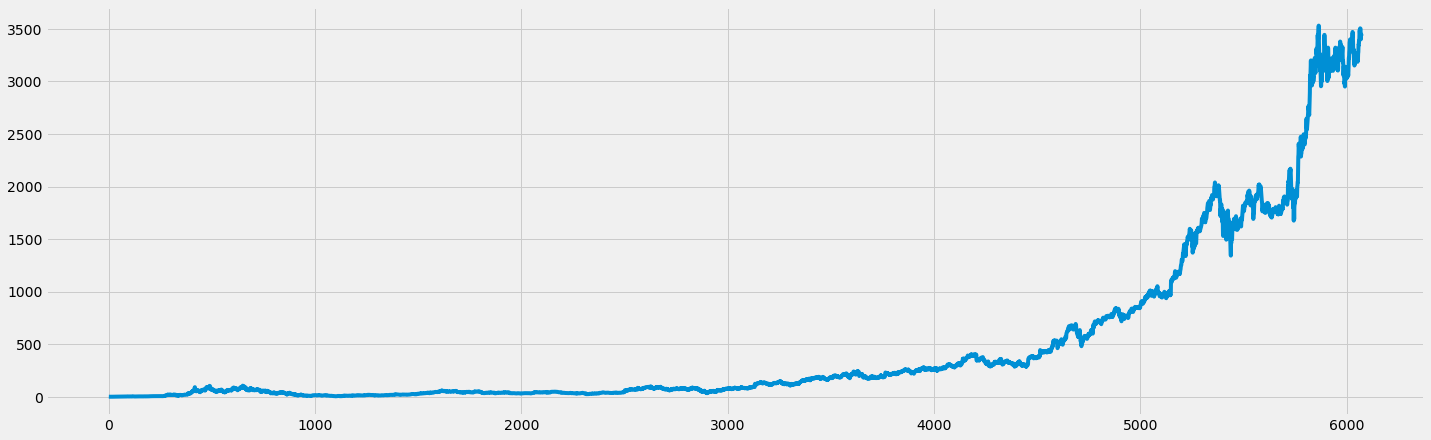

In [124]:
plt.plot(df_training);

In [125]:
scaler = MinMaxScaler(feature_range=(0,1))
df_training = scaler.fit_transform(np.array(df_training).reshape(-1,1))
df_training.shape


(6073, 1)

In [126]:
training_size = int(len(df_training)*0.75)
test_size = len(df_training)- training_size
train_data, test_data = df_training[0:training_size], df_training[training_size:len(df_training), :]
train_data.shape, test_data.shape

((4554, 1), (1519, 1))

In [127]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+ time_step, 0])
    return np.array(dataX),np.array(dataY)

time_step = 122
X_train , y_train  = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4431, 122), (4431,), (1396, 122), (1396,))

In [128]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
X_train.shape, X_test.shape

((4431, 122, 1), (1396, 122, 1))

In [129]:
model = Sequential()
model.add(LSTM(units=50, return_sequences = True, input_shape= (X_train.shape[1],1)))
#model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences = True))
#model.add(Dropout(0.3))

model.add(LSTM(units=50))
#model.add(Dropout(0.4))

#model.add(LSTM(units=120, activation = 'relu'))
#model.add(Dropout(0.5))
        
model.add(Dense(units=1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 122, 50)           10400     
                                                                 
 lstm_19 (LSTM)              (None, 122, 50)           20200     
                                                                 
 lstm_20 (LSTM)              (None, 50)                20200     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [130]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20,batch_size=64, verbose=1 )

Epoch 1/20
70/70 [==============================] - 31s 353ms/step - loss: 1.1394e-04 - val_loss: 0.0051
Epoch 2/20
70/70 [==============================] - 24s 341ms/step - loss: 7.1872e-06 - val_loss: 0.0032
Epoch 3/20
70/70 [==============================] - 24s 347ms/step - loss: 8.4218e-06 - val_loss: 0.0027
Epoch 4/20
70/70 [==============================] - 24s 345ms/step - loss: 7.7075e-06 - val_loss: 0.0050
Epoch 5/20
70/70 [==============================] - 21s 300ms/step - loss: 7.3350e-06 - val_loss: 0.0025
Epoch 6/20
70/70 [==============================] - 20s 292ms/step - loss: 7.6267e-06 - val_loss: 0.0034
Epoch 7/20
70/70 [==============================] - 22s 319ms/step - loss: 6.1045e-06 - val_loss: 0.0020
Epoch 8/20
70/70 [==============================] - 23s 325ms/step - loss: 6.2406e-06 - val_loss: 0.0031
Epoch 9/20
70/70 [==============================] - 21s 300ms/step - loss: 6.5241e-06 - val_loss: 0.0018
Epoch 10/20
70/70 [==============================] - 22

In [131]:
model.save("20epoch_amzn.h5")
train_predict = scaler.inverse_transform(model.predict(X_train))
test_predict = scaler.inverse_transform(model.predict(X_test))
print(mean_squared_error(y_train, train_predict, squared=False))
print(mean_squared_error(y_test, test_predict, squared=False))

151.23805160329746
1776.0497084224821


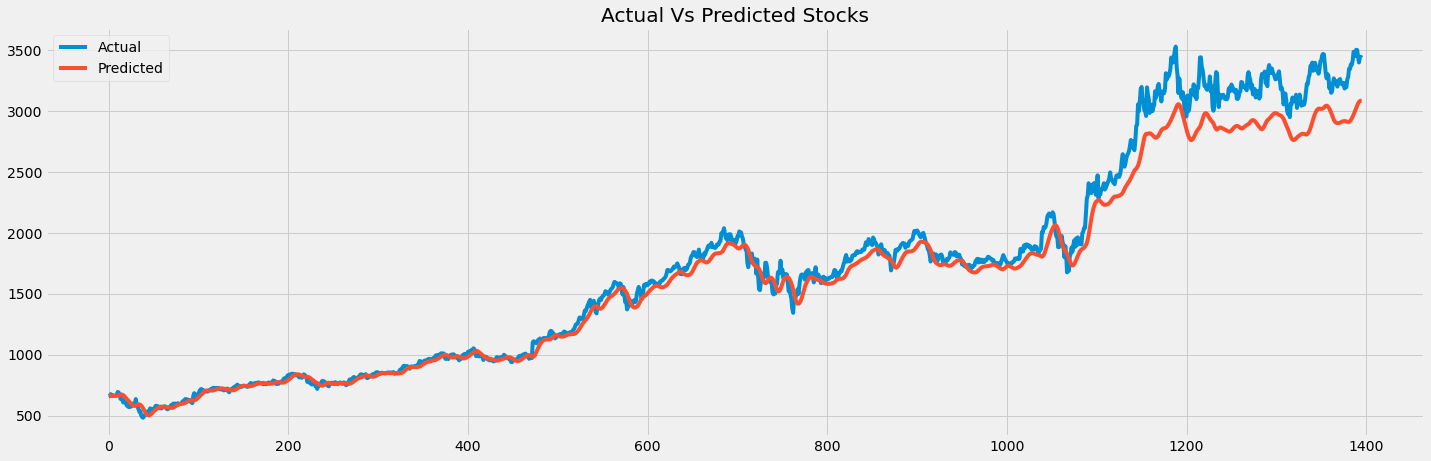

In [132]:
plt.plot(scaler.inverse_transform(y_test.reshape(-1,1)))
plt.plot(test_predict)
plt.legend(['Actual', 'Predicted'])
plt.title('Actual Vs Predicted Stocks');

In [133]:
print(len(test_data))
print(test_data.shape)
X_input=test_data[-122:].reshape(1,-1)
print(X_input.shape)
temp_input=list(X_input)
temp_input=temp_input[0].tolist()
len(temp_input)

1519
(1519, 1)
(1, 122)


122

In [134]:
lst_output=[]
n_steps=122
i=0
while(i<122):
    
    if(len(temp_input)>122):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = X_input.reshape((1, n_steps ,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    
print(lst_output)

[0.87308747]
123
1 day input [0.90120548 0.88180351 0.88367887 0.8964435  0.88555983 0.87898204
 0.88365902 0.92406063 0.93641458 0.93223334 0.93273476 0.94183657
 0.91533561 0.91676336 0.9078626  0.94658154 0.95709699 0.93798398
 0.94321618 0.94920756 0.94093291 0.93585086 0.93063283 0.92370653
 0.92812008 0.92563853 0.93688197 0.94243149 0.920242   0.90065026
 0.90454822 0.89464186 0.86564228 0.87577527 0.89084868 0.87622855
 0.85086632 0.84309592 0.84958021 0.83583821 0.8672542  0.86577825
 0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141

6 day output [[0.81410927]]
7 day input [0.88365902 0.92406063 0.93641458 0.93223334 0.93273476 0.94183657
 0.91533561 0.91676336 0.9078626  0.94658154 0.95709699 0.93798398
 0.94321618 0.94920756 0.94093291 0.93585086 0.93063283 0.92370653
 0.92812008 0.92563853 0.93688197 0.94243149 0.920242   0.90065026
 0.90454822 0.89464186 0.86564228 0.87577527 0.89084868 0.87622855
 0.85086632 0.84309592 0.84958021 0.83583821 0.8672542  0.86577825
 0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061
 0.91511464 0.91961312

12 day output [[0.7406645]]
13 day input [0.91533561 0.91676336 0.9078626  0.94658154 0.95709699 0.93798398
 0.94321618 0.94920756 0.94093291 0.93585086 0.93063283 0.92370653
 0.92812008 0.92563853 0.93688197 0.94243149 0.920242   0.90065026
 0.90454822 0.89464186 0.86564228 0.87577527 0.89084868 0.87622855
 0.85086632 0.84309592 0.84958021 0.83583821 0.8672542  0.86577825
 0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061
 0.91511464 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488
 0.91463591 0.9126416

18 day output [[0.68338156]]
19 day input [0.94321618 0.94920756 0.94093291 0.93585086 0.93063283 0.92370653
 0.92812008 0.92563853 0.93688197 0.94243149 0.920242   0.90065026
 0.90454822 0.89464186 0.86564228 0.87577527 0.89084868 0.87622855
 0.85086632 0.84309592 0.84958021 0.83583821 0.8672542  0.86577825
 0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061
 0.91511464 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488
 0.91463591 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827
 0.90554254 0.924267

24 day output [[0.63881]]
25 day input [0.92812008 0.92563853 0.93688197 0.94243149 0.920242   0.90065026
 0.90454822 0.89464186 0.86564228 0.87577527 0.89084868 0.87622855
 0.85086632 0.84309592 0.84958021 0.83583821 0.8672542  0.86577825
 0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061
 0.91511464 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488
 0.91463591 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827
 0.90554254 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332
 0.95798363 0.96708267 

30 day output [[0.6031173]]
31 day input [0.90454822 0.89464186 0.86564228 0.87577527 0.89084868 0.87622855
 0.85086632 0.84309592 0.84958021 0.83583821 0.8672542  0.86577825
 0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061
 0.91511464 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488
 0.91463591 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827
 0.90554254 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332
 0.95798363 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184
 0.99217296 0.9766661

36 day output [[0.57356894]]
37 day input [0.85086632 0.84309592 0.84958021 0.83583821 0.8672542  0.86577825
 0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061
 0.91511464 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488
 0.91463591 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827
 0.90554254 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332
 0.95798363 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184
 0.99217296 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392
 0.97210242 0.8730874

 0.55640191 0.55237395]
42 day output [[0.5484425]]
43 day input [0.88162792 0.8748008  0.87258835 0.87547221 0.88789974 0.85737897
 0.8706847  0.8808574  0.88840116 0.87411528 0.86255453 0.86418907
 0.87090284 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406
 0.92859598 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275
 0.95683923 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533
 0.94601497 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146
 0.95893548 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226
 0.91287951 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061
 0.91511464 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488
 0.91463591 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827
 0.90554254 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332
 0.95798363 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184
 0.99217296 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392
 0.97210242 0.87308747 0.86907095 0.86174858 0.85178888 0.8400446

49 day output [[0.52333]]
50 day input [0.8808574  0.88840116 0.87411528 0.86255453 0.86418907 0.87090284
 0.86511257 0.87610109 0.89505828 0.91367839 0.91285406 0.92859598
 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275 0.95683923
 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533 0.94601497
 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146 0.95893548
 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226 0.91287951
 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061 0.91511464
 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 

55 day output [[0.504641]]
56 day input [0.86511257 0.87610109 0.89505828 0.91367839 0.91285406 0.92859598
 0.93423616 0.95488738 0.95692416 0.96276262 0.94378275 0.95683923
 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533 0.94601497
 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146 0.95893548
 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226 0.91287951
 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061 0.91511464
 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586

61 day output [[0.48807105]]
62 day input [0.93423616 0.95488738 0.95692416 0.96276262 0.94378275 0.95683923
 0.96260397 0.95483357 0.94426147 0.95200359 0.93699533 0.94601497
 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146 0.95893548
 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226 0.91287951
 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061 0.91511464
 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.632332

67 day output [[0.47326228]]
68 day input [0.96260397 0.95483357 0.94426147 0.95200359 0.93699533 0.94601497
 0.96531216 0.96770021 0.97933461 0.98296346 0.98186146 0.95893548
 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226 0.91287951
 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061 0.91511464
 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.597823

73 day output [[0.4599323]]
74 day input [0.96531216 0.96770021 0.97933461 0.98296346 0.98186146 0.95893548
 0.93779703 0.92608898 0.93623898 0.93205774 0.90341226 0.91287951
 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061 0.91511464
 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033
 0.57356894 0.5691091

79 day output [[0.44785613]]
80 day input [0.93779703 0.92608898 0.93623898 0.93205774 0.90341226 0.91287951
 0.89249173 0.89519141 0.91259339 0.92604644 0.91525061 0.91511464
 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033
 0.57356894 0.56910914 0.5647648  0.56053066 0.55640191 0.55237395
 0.54844248 0.544603

85 day output [[0.43685308]]
86 day input [0.89249173 0.89519141 0.91259339 0.92604644 0.91525061 0.91511464
 0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033
 0.57356894 0.56910914 0.5647648  0.56053066 0.55640191 0.55237395
 0.54844248 0.54460388 0.54085433 0.53719038 0.53360891 0.53010678
 0.52668142 0.523329

91 day output [[0.42677665]]
92 day input [0.91961312 0.9069788  0.91885111 0.92283407 0.92456488 0.91463591
 0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033
 0.57356894 0.56910914 0.5647648  0.56053066 0.55640191 0.55237395
 0.54844248 0.54460388 0.54085433 0.53719038 0.53360891 0.53010678
 0.52668142 0.52332997 0.52004987 0.51683879 0.51369458 0.51061487
 0.50759774 0.504641

97 day output [[0.41750705]]
98 day input [0.9126416  0.91138945 0.91573501 0.90242644 0.90786827 0.90554254
 0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033
 0.57356894 0.56910914 0.5647648  0.56053066 0.55640191 0.55237395
 0.54844248 0.54460388 0.54085433 0.53719038 0.53360891 0.53010678
 0.52668142 0.52332997 0.52004987 0.51683879 0.51369458 0.51061487
 0.50759774 0.504641   0.50174302 0.49890175 0.4961156  0.49338287
 0.49070182 0.488071

103 day output [[0.40894488]]
104 day input [0.92426749 0.92909456 0.94849936 0.94770055 0.95819332 0.95798363
 0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033
 0.57356894 0.56910914 0.5647648  0.56053066 0.55640191 0.55237395
 0.54844248 0.54460388 0.54085433 0.53719038 0.53360891 0.53010678
 0.52668142 0.52332997 0.52004987 0.51683879 0.51369458 0.51061487
 0.50759774 0.504641   0.50174302 0.49890175 0.4961156  0.49338287
 0.49070182 0.48807105 0.48548913 0.48295444 0.48046562 0.47802153
 0.47562081 0.4732

109 day output [[0.4010069]]
110 day input [0.96708267 0.98804269 0.98737978 0.9780485  0.99263184 0.99217296
 0.97666612 0.9631762  0.97519583 0.97639978 0.9741392  0.97210242
 0.87308747 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708
 0.81410927 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263
 0.74066448 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821
 0.68338156 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106
 0.63880998 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958
 0.60311729 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033
 0.57356894 0.56910914 0.5647648  0.56053066 0.55640191 0.55237395
 0.54844248 0.54460388 0.54085433 0.53719038 0.53360891 0.53010678
 0.52668142 0.52332997 0.52004987 0.51683879 0.51369458 0.51061487
 0.50759774 0.504641   0.50174302 0.49890175 0.4961156  0.49338287
 0.49070182 0.48807105 0.48548913 0.48295444 0.48046562 0.47802153
 0.47562081 0.47326228 0.47094464 0.46866679 0.46642762 0.46422616
 0.46206129 0.45993

116 day output [[0.39244208]]
117 day input [0.9631762  0.97519583 0.97639978 0.9741392  0.97210242 0.87308747
 0.86907095 0.86174858 0.85178888 0.84004468 0.82728708 0.81410927
 0.8009212  0.7879805  0.7754336  0.76335216 0.75176263 0.74066448
 0.73004448 0.71988267 0.71015757 0.70084655 0.69192821 0.68338156
 0.67518586 0.66732174 0.65976977 0.65251225 0.64553106 0.63880998
 0.63233256 0.62608445 0.62005168 0.6142205  0.60857958 0.60311729
 0.59782332 0.59268802 0.58770281 0.58285928 0.57815033 0.57356894
 0.56910914 0.5647648  0.56053066 0.55640191 0.55237395 0.54844248
 0.54460388 0.54085433 0.53719038 0.53360891 0.53010678 0.52668142
 0.52332997 0.52004987 0.51683879 0.51369458 0.51061487 0.50759774
 0.504641   0.50174302 0.49890175 0.4961156  0.49338287 0.49070182
 0.48807105 0.48548913 0.48295444 0.48046562 0.47802153 0.47562081
 0.47326228 0.47094464 0.46866679 0.46642762 0.46422616 0.46206129
 0.4599323  0.45783785 0.45577741 0.45374966 0.45175415 0.44978988
 0.44785613 0.4459

In [137]:
df_test = data.DataReader('AMZN', 'yahoo', '2021-07-02', '2021-12-24')
df_test = df_test[['Close']]
df_test

,Close
Date,
2021-07-02,3510.979980
2021-07-06,3675.739990
2021-07-07,3696.580078
2021-07-08,3731.409912
2021-07-09,3719.340088
...,...
2021-12-17,3400.350098
2021-12-20,3341.580078
2021-12-21,3408.340088


In [148]:
(df_test.Close.values)

array([3510.97998047, 3675.73999023, 3696.58007812, 3731.40991211,
       3719.34008789, 3718.55004883, 3677.36010742, 3681.67993164,
       3631.19995117, 3573.62988281, 3549.59008789, 3573.18994141,
       3585.19995117, 3638.0300293 , 3656.63989258, 3699.82006836,
       3626.38989258, 3630.32006836, 3599.91992188, 3327.59008789,
       3331.47998047, 3366.23999023, 3354.7199707 , 3375.98999023,
       3344.93994141, 3341.87011719, 3320.67993164, 3292.11010742,
       3303.5       , 3293.9699707 , 3298.98999023, 3241.95996094,
       3201.2199707 , 3187.75      , 3199.94995117, 3265.87011719,
       3305.7800293 , 3299.17993164, 3316.        , 3349.62988281,
       3421.57006836, 3470.79003906, 3479.        , 3463.12011719,
       3478.05004883, 3509.29003906, 3525.5       , 3484.15991211,
       3469.14990234, 3457.16992188, 3450.        , 3475.79003906,
       3488.23999023, 3462.52001953, 3355.72998047, 3343.62988281,
       3380.05004883, 3416.        , 3425.52001953, 3405.80004

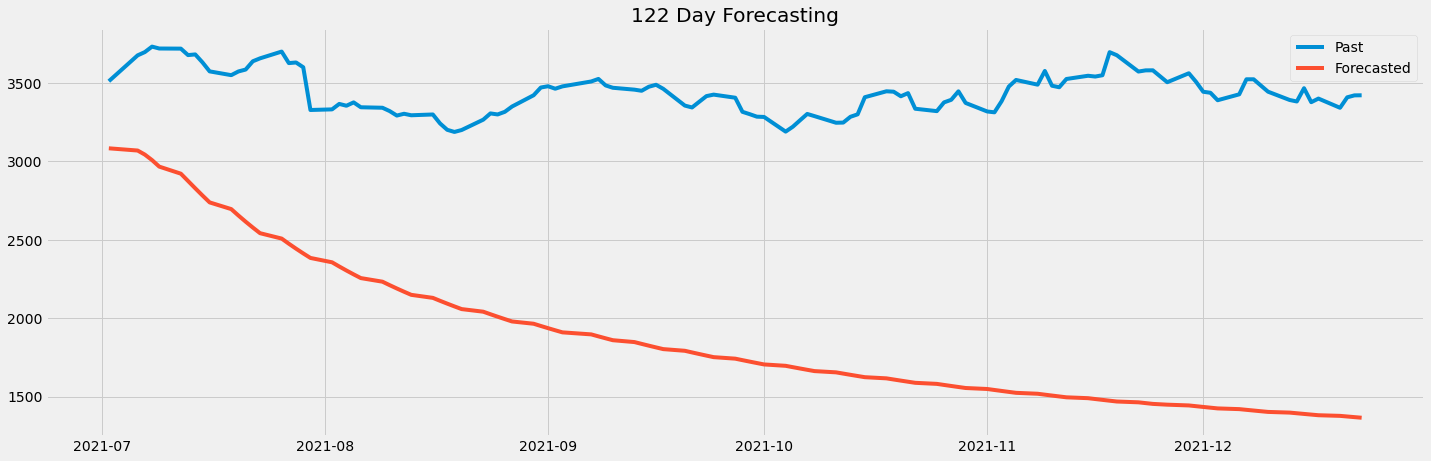

In [146]:
plt.plot(df_test.index, (df_test.Close.values))
plt.plot(df_test.index, scaler.inverse_transform(lst_output))
plt.legend(['Past', 'Forecasted'])
plt.title('122 Day Forecasting');

In [147]:
scaler.inverse_transform(lst_output)

array([[3083.44183704],
       [3069.26330904],
       [3043.41494312],
       [3008.25667116],
       [2966.7990054 ],
       [2921.76398927],
       [2875.2455994 ],
       [2828.69101942],
       [2783.00963107],
       [2738.71840587],
       [2696.0702538 ],
       [2655.15859582],
       [2615.98153828],
       [2578.49237069],
       [2542.62060648],
       [2508.29049891],
       [2475.4220931 ],
       [2443.93985269],
       [2413.76971422],
       [2384.83845582],
       [2357.07769502],
       [2330.41883894],
       [2304.7993965 ],
       [2280.15540381],
       [2256.42962997],
       [2233.56400249],
       [2211.50781313],
       [2190.21182651],
       [2169.62743847],
       [2149.71467155],
       [2130.43249628],
       [2111.74451213],
       [2093.61663307],
       [2076.01856041],
       [2058.92062666],
       [2042.29779331],
       [2026.12523228],
       [2010.3819028 ],
       [1995.04613288],
       [1980.09940666],
       [1965.5246811 ],
       [1951.305